In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from datetime import datetime
import yfinance as yf

# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# Fetch the stock data
company_data = {}

for stock in tech_list:
    company_data[stock] = yf.download(stock, start=start, end=end,actions=False)

# Add company name to each DataFrame and concatenate into a single DataFrame
company_list = [company_data[stock] for stock in tech_list]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for df, name in zip(company_list, company_name):
    df["company_name"] = name

df = pd.concat(company_list, axis=0)
print(df.tail(10))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-23  184.100006  189.389999  183.559998  186.410004  186.410004   
2024-07-24  183.199997  185.449997  180.410004  180.830002  180.830002   
2024-07-25  182.910004  183.899994  176.800003  179.850006  179.850006   
2024-07-26  180.389999  183.190002  180.240005  182.500000  182.500000   
2024-07-29  183.839996  184.750000  182.380005  183.199997  183.199997   
2024-07-30  184.720001  185.860001  179.380005  181.710007  181.710007   
2024-07-31  185.050003  187.940002  184.460007  186.979996  186.979996   
2024-08-01  189.289993  190.600006  181.869995  184.070007  184.070007   
2024-08-02  166.750000  168.770004  160.550003  167.899994  167.899994   
2024-08-05  154.154999  162.960007  151.610001  161.020004  161.020004   

               Volume company_name  
Date                                
2024-07-23   47537700       AMAZON  


In [2]:
# imports 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from datetime import datetime
import yfinance as yf

# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

# Fetch the stock data
company_data = {}

for stock in tech_list:
    company_data[stock] = yf.download(stock, start=start, end=end)

# Add company name to each DataFrame and concatenate into a single DataFrame
company_list = [company_data[stock] for stock in tech_list]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for df, name in zip(company_list, company_name):
    df["company_name"] = name

df = pd.concat(company_list, axis=0)

# Print example of the first 10 stocks
print(df.tail(10))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-23  184.100006  189.389999  183.559998  186.410004  186.410004   
2024-07-24  183.199997  185.449997  180.410004  180.830002  180.830002   
2024-07-25  182.910004  183.899994  176.800003  179.850006  179.850006   
2024-07-26  180.389999  183.190002  180.240005  182.500000  182.500000   
2024-07-29  183.839996  184.750000  182.380005  183.199997  183.199997   
2024-07-30  184.720001  185.860001  179.380005  181.710007  181.710007   
2024-07-31  185.050003  187.940002  184.460007  186.979996  186.979996   
2024-08-01  189.289993  190.600006  181.869995  184.070007  184.070007   
2024-08-02  166.750000  168.770004  160.550003  167.899994  167.899994   
2024-08-05  154.154999  162.960007  151.610001  161.020004  161.020004   

               Volume company_name  
Date                                
2024-07-23   47537700       AMAZON  


In [3]:
# Describe the dataset statistically 
print(company_data['AAPL'].describe())

              Open         High          Low        Close    Adj Close  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean    139.918858   141.497935   138.452150   140.042311   138.445663   
std      42.068417    42.374812    41.757471    42.059278    42.487581   
min      48.852501    49.517502    48.145000    48.334999    46.647968   
25%     119.146248   120.514999   117.080002   119.040001   116.566360   
50%     146.979996   148.720001   145.550003   146.919998   144.963272   
75%     171.865005   173.684998   170.689995   172.224998   170.781776   
max     236.479996   237.229996   233.089996   234.820007   234.820007   

             Volume  
count  1.259000e+03  
mean   9.546908e+07  
std    5.205248e+07  
min    2.404830e+07  
25%    6.091975e+07  
50%    8.180320e+07  
75%    1.122336e+08  
max    4.265100e+08  


In [4]:
# Describe concisely the features,
# including the number of non-null values and data types
print(company_data['AAPL'].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-08-05 to 2024-08-05
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Adj Close     1259 non-null   float64
 5   Volume        1259 non-null   int64  
 6   company_name  1259 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 78.7+ KB
None


In [5]:
# Displaying rows and columns for the complete dataset
print("Dimensions of the Data:", df.shape)

Dimensions of the Data: (5036, 7)


In [6]:
# Displaying rows and columns for Apple
print("Dimensions of the Data:", company_data['AAPL'].shape)

Dimensions of the Data: (1259, 7)


In [7]:
# Displaying rows and columns for Google
print(company_data['GOOG'].info())

# Describe concisely the features,
# including the number of non-null values and data types for Google 
print("Dimensions of the Data:", company_data['GOOG'].shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-08-05 to 2024-08-05
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Adj Close     1259 non-null   float64
 5   Volume        1259 non-null   int64  
 6   company_name  1259 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 78.7+ KB
None
Dimensions of the Data: (1259, 7)


In [8]:
# Data Cleaning 
# Handling Missing Values 

# Checking and printing for Missing Values (NaN) in the datasets
print("Are there any missing points in the dataset?:", df.isnull().values.any(), "\n")

Are there any missing points in the dataset?: False 



In [9]:
# Handling Duplicate Values:
# Checking and printing for duplicated rows in the DataFrame
print("Number of Duplicated Rows:", df.duplicated().sum(), "\n")

Number of Duplicated Rows: 0 



In [10]:
# No need to remove duplicated and recheck 
# for dimensions because there are no duplicate

In [11]:
from sklearn.model_selection import train_test_split
data = company_data['AAPL']
#data = df 
# Prepare features and target
data['Target'] = data['Close'].shift(-1)  # Predict next day's price
data = data.dropna()
X = data[['Close']]
y = data['Target']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Verify the sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 754
Validation set size: 252
Test set size: 252


<Axes: >

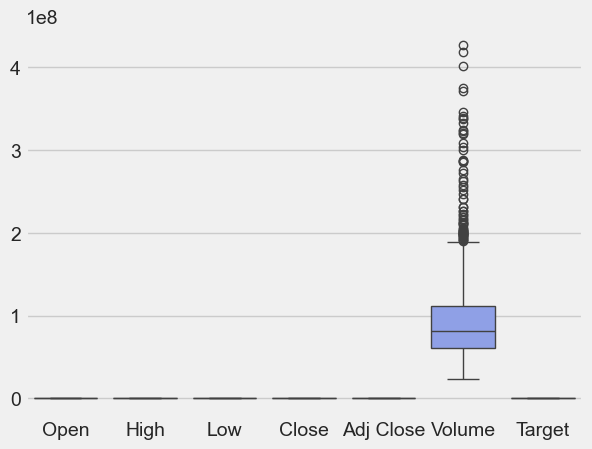

In [12]:
import seaborn as sns
sns.boxplot(data)

In [13]:
from scipy import stats

# Example DataFrame
data = df

# Ensure the data is numeric
numeric_data = data.select_dtypes(include=[np.number])

# Calculate z-scores
z_scores = stats.zscore(numeric_data)

# Identify outliers
outliers = (np.abs(z_scores) > 3)
            
# Print outliers
print("Outlier rows (True indicates an outlier):")
print(outliers)

Outlier rows (True indicates an outlier):
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2019-08-05  False  False  False  False      False    True
2019-08-06  False  False  False  False      False   False
2019-08-07  False  False  False  False      False   False
2019-08-08  False  False  False  False      False   False
2019-08-09  False  False  False  False      False   False
...           ...    ...    ...    ...        ...     ...
2024-07-30  False  False  False  False      False   False
2024-07-31  False  False  False  False      False   False
2024-08-01  False  False  False  False      False   False
2024-08-02  False  False  False  False      False   False
2024-08-05  False  False  False  False      False   False

[5036 rows x 6 columns]


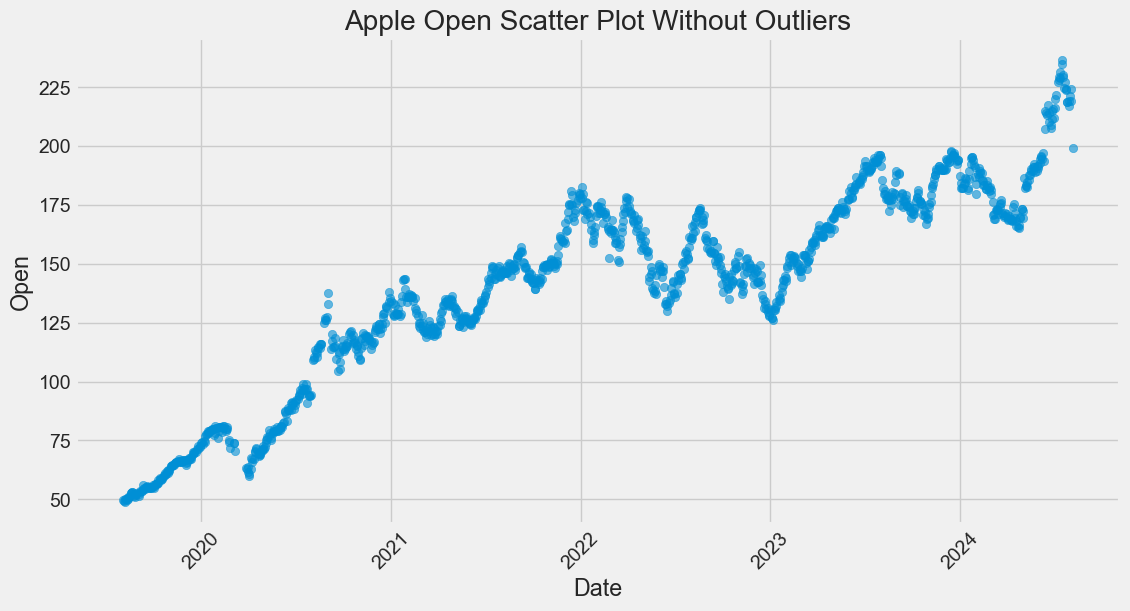

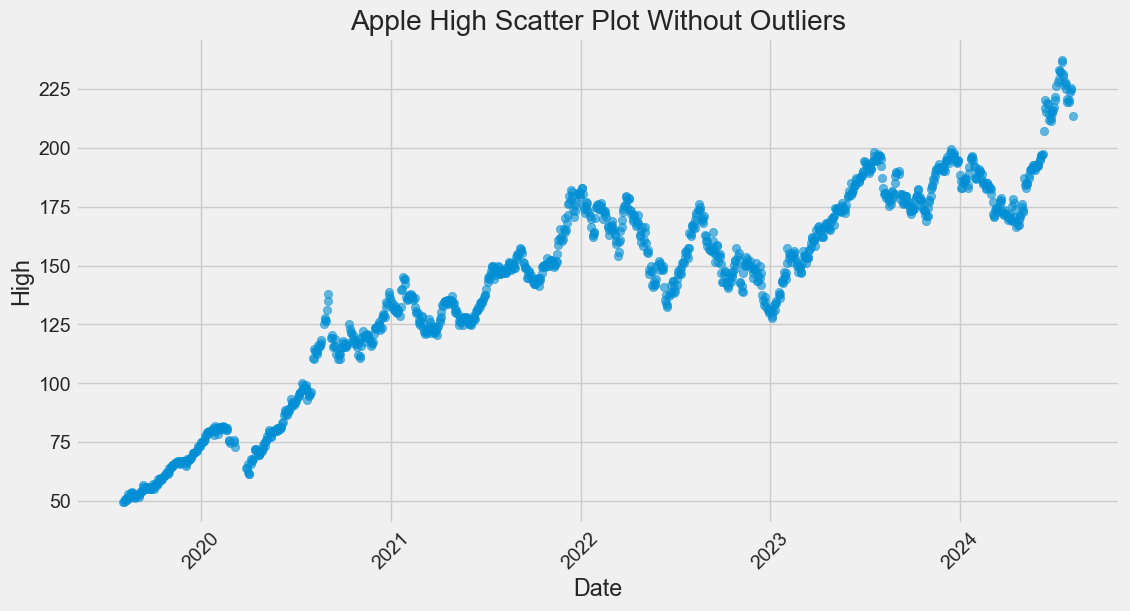

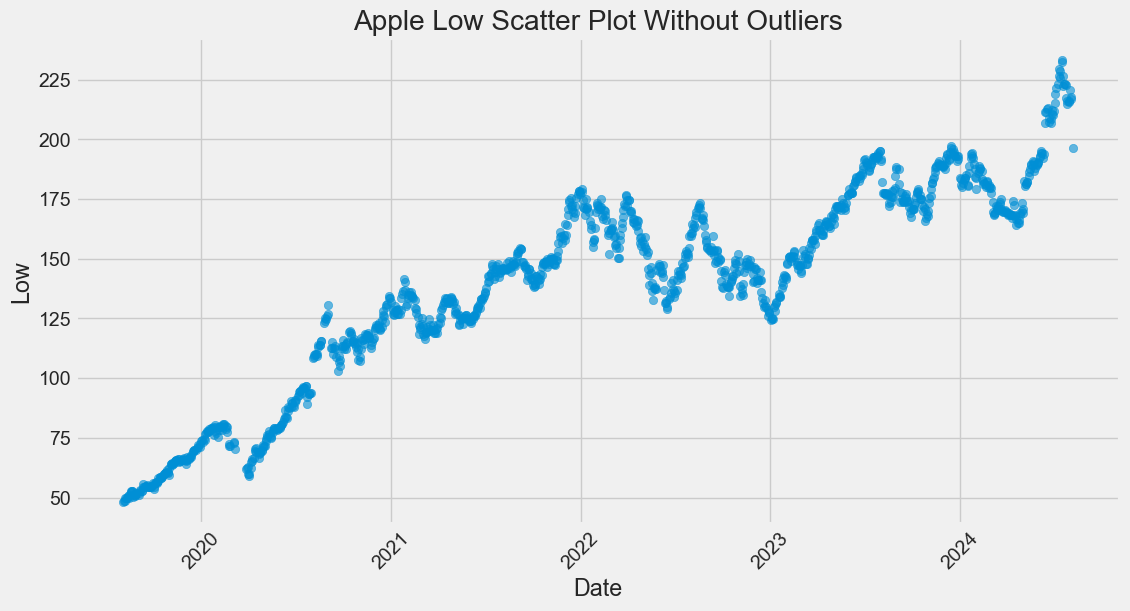

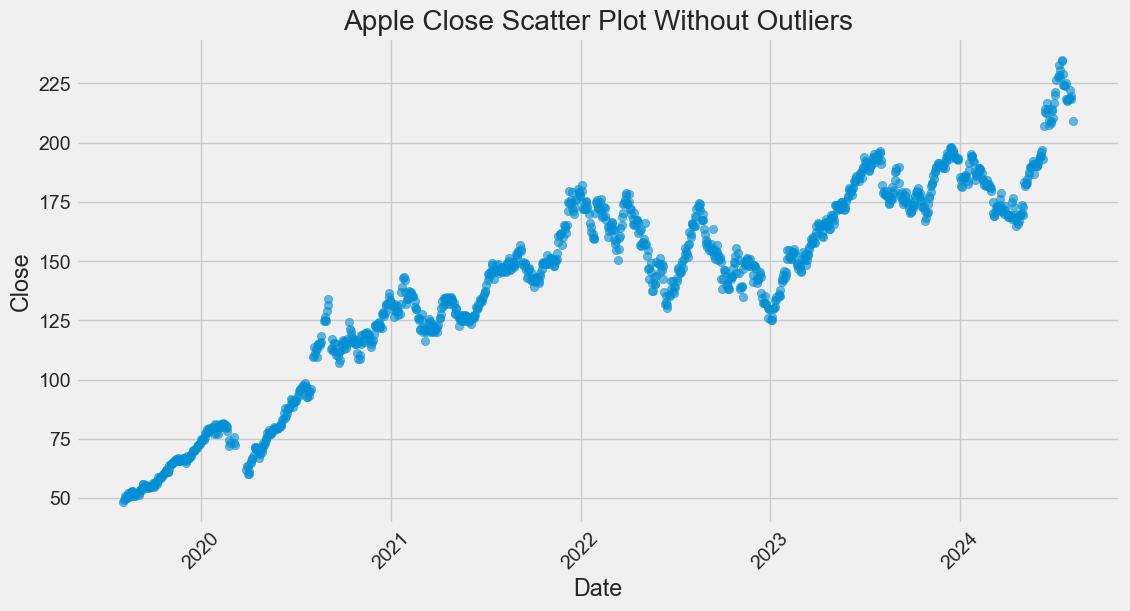

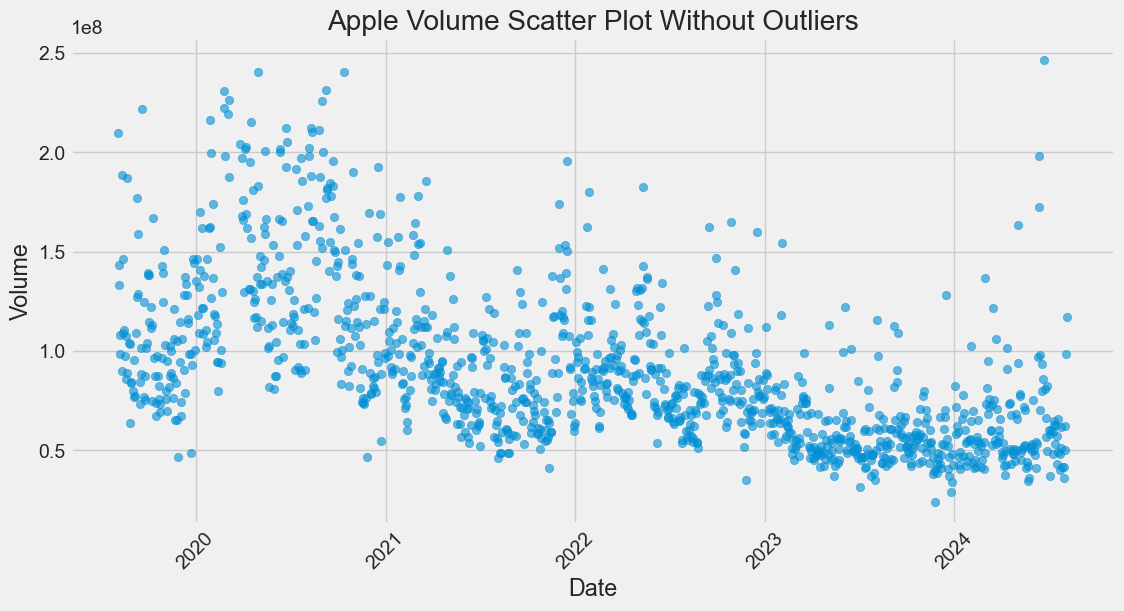

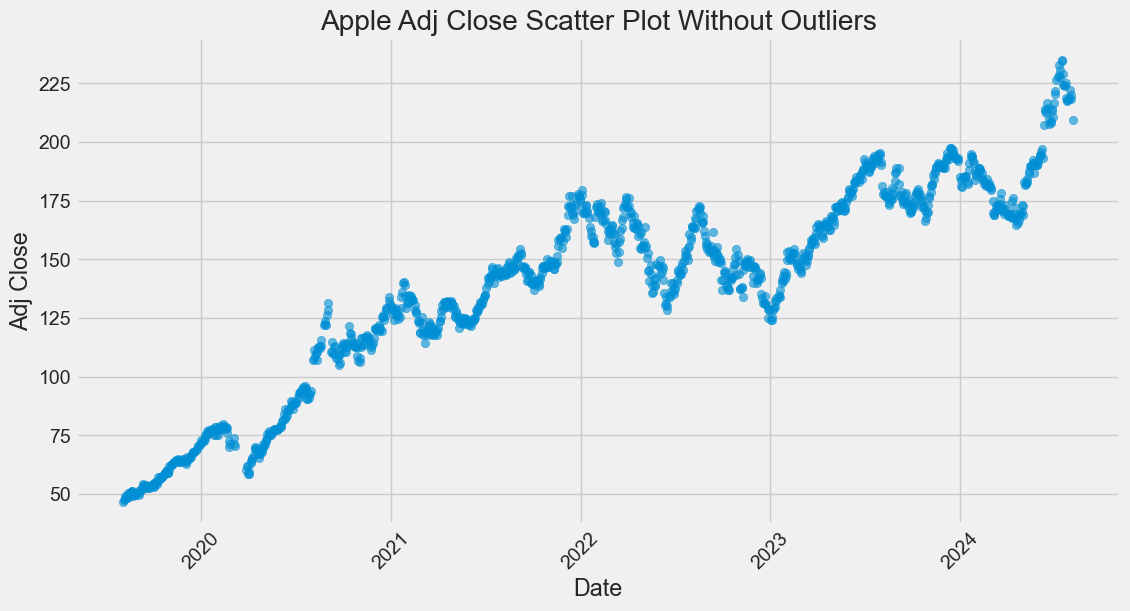

In [15]:
data = company_data['AAPL']
columns_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
data = data[columns_to_keep]

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

#handle outliers with a method
def remove_outliers(df):
    z_scores = stats.zscore(df.select_dtypes(include=[np.number]))
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return df[filtered_entries]

#use the method for the company
data_cleaned=remove_outliers(data)

numerical_columns = data_cleaned.select_dtypes(include=[np.number]).columns

#show the results
for column in numerical_columns:
    plt.figure(figsize=(12, 6))
    plt.scatter(data_cleaned.index, data_cleaned[column], alpha=0.6)
    plt.title(f'Apple {column} Scatter Plot Without Outliers')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.show()
#print(data_cleaned.tail(10))

In [ ]:
print("boomboom")
print("hello")
print("goodbye")
print("boom shaka laka")